This is a notebook for exploring the capabilities of the Protest Activity Detection and Percieved Violence Estimation algorithm and attempting to explain the algorithm's predictions using GradCam.

Retrieve the pretrained weights

In [ ]:
!wget 'https://www.dropbox.com/s/rxslj6x01otf62i/model_best.pth.tar?dl=0'

--2022-02-10 15:38:47--  https://www.dropbox.com/s/rxslj6x01otf62i/model_best.pth.tar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6034:18::a27d:5412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rxslj6x01otf62i/model_best.pth.tar [following]
--2022-02-10 15:38:47--  https://www.dropbox.com/s/raw/rxslj6x01otf62i/model_best.pth.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbaf4dde0fe80d5517506013100.dl.dropboxusercontent.com/cd/0/inline/BfcjXlCQuOCXllYTXSsOP-YC-4m5CzoEQ81NYrgFNmzuaTuX3NYu67-L6BQPgsC2e3bw8zJWPdUm5mljnOJYW6pOC9lTUb0OoSAe0Kb6lHuR43p_sSdrSiIbTaH8vFypJdiVKEpHjfhKJB93rCxIpNQm/file# [following]
--2022-02-10 15:38:48--  https://ucbaf4dde0fe80d5517506013100.dl.dropboxusercontent.com/cd/0/inline/BfcjXlCQuOCXllYTXSsOP-YC-4m5CzoEQ81NYrgFNmzuaTuX3NYu67-L6BQPgsC2e3

Retrieve UCLA Protest Dataset

In [ ]:
!wget 'https://ucla.app.box.com/s/2i54ltxqb4es0yrd0sszgobkeqm7ovgi#:~:text=ucla-protest.zip-,Download,-Sign%20up'

--2022-02-09 21:15:16--  https://ucla.app.box.com/s/2i54ltxqb4es0yrd0sszgobkeqm7ovgi
Resolving ucla.app.box.com (ucla.app.box.com)... 107.152.24.201
Connecting to ucla.app.box.com (ucla.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘2i54ltxqb4es0yrd0sszgobkeqm7ovgi.1’

2i54ltxqb4es0yrd0ss     [  <=>               ]  14.28K  29.6KB/s    in 0.5s    

2022-02-09 21:15:17 (29.6 KB/s) - ‘2i54ltxqb4es0yrd0sszgobkeqm7ovgi.1’ saved [14619]



Configure path to weights either from scratch or from pretraining, and set path to dataset

In [ ]:
img_path = '/content/drive/MyDrive/CustomData'
weight_path = '/content/drive/MyDrive/model_best.pth.tar'

In [ ]:
!python /content/protest-detection-violence-estimation/pred.py --img_dir /content/Images --output_csvpath result.csv --model /content/model_best.pth.tar?dl=0 --cuda

*** loading model from /content/model_best.pth.tar?dl=0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:02<00:00, 37.5MB/s]
*** calculating the model output of the images in /content/Images
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
16it [00:00, 23.28it/s]


In [ ]:
!pip install torchvision matplotlib
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/torch-cam.git#egg=torchcam

Obtaining torchcam from git+https://github.com/frgfm/torch-cam.git#egg=torchcam
  Updating ./src/torchcam clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 3179f51036e08885cbc9190ed01841cb2f6caf2f
  Attempting uninstall: torchcam
    Found existing installation: torchcam 0.3.2.dev0+3179f51
    Can't uninstall 'torchcam'. No files were found to uninstall.
  Running setup.py develop for torchcam


Initializing GradCam for Data Visualization

In [ ]:
%matplotlib inline
# All imports
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [ ]:
# Download Random Images or use Images from the Dataset folder
!wget https://ichef.bbci.co.uk/news/976/cpsprodpb/B228/production/_119080654_gettyimages-1230455457-594x594.jpg
!wget https://braintumor.org/wp-content/assets/Happy-Crowd.png
!wget https://www.economist.com/img/b/1280/720/90/sites/default/files/images/print-edition/20110813_BRP001_0.jpg
!wget https://static3.bigstockphoto.com/8/9/3/large1500/39852808.jpg

# Set this to your image path if you wish to run it on your own data
img_path = "/content/riot-arrest.jpg"

--2022-02-10 15:42:27--  https://ichef.bbci.co.uk/news/976/cpsprodpb/B228/production/_119080654_gettyimages-1230455457-594x594.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 184.28.154.140, 2600:1409:9800:a89::f33, 2600:1409:9800:a86::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|184.28.154.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152055 (148K) [image/jpeg]
Saving to: ‘_119080654_gettyimages-1230455457-594x594.jpg.3’

_119080654_gettyima 100%[===================>] 148.49K  --.-KB/s    in 0.02s   

2022-02-10 15:42:27 (7.30 MB/s) - ‘_119080654_gettyimages-1230455457-594x594.jpg.3’ saved [152055/152055]

--2022-02-10 15:42:28--  https://braintumor.org/wp-content/assets/Happy-Crowd.png
Resolving braintumor.org (braintumor.org)... 104.196.146.106
Connecting to braintumor.org (braintumor.org)|104.196.146.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888808 (868K) [image/png]
Saving to: ‘Happy-Crowd.png.2

In [ ]:
from util import modified_resnet50()

In [ ]:
model = modified_resnet50()

In [ ]:
with open('/content/model_best.pth.tar?dl=0', 'rb') as f:
        model.load_state_dict(torch.load(f)['state_dict'])

In [ ]:
cam_extractor = SmoothGradCAMpp(model)
# Get your input
img = read_image(img_path)
img.size
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
img.shape

torch.Size([3, 687, 1200])

In [ ]:
cams = cams.pop(0)
for cam in cams:
  print(cam.shape)

torch.Size([7, 7])


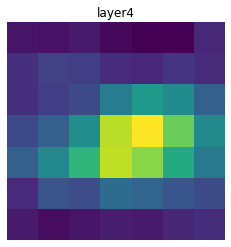

In [ ]:
# The raw CAM
for name, cam in zip(cam_extractor.target_names, cams):
  plt.imshow(cam.numpy()); plt.axis('off'); plt.title(name); plt.show()

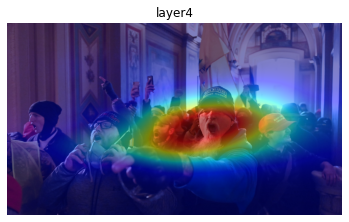

In [ ]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  result = overlay_mask(to_pil_image(img), to_pil_image(cam, mode='F'), alpha=0.5)
  plt.imshow(result); plt.axis('off'); plt.title(name); plt.show()

In [ ]:
cam_extractor.clear_hooks()

AttributeError: ignored